<a href="https://colab.research.google.com/github/matheusbgomes4/Home_Credito_inadimplencia/blob/main/Home_Credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 1 Introdução

Este notebook realiza uma análise preditiva de risco de crédito usando dados da Kaggle Home Credit.
O objetivo principal é prever a probabilidade de um cliente se tornar inadimplente ('TARGET' = 1).

Aqui integramos a base principal `application_train.csv` com as bases auxiliares `bureau.csv`, `previous_application.csv` e `credit_card_balance.csv`
para enriquecer a modelagem e capturar padrões mais completos.

O fluxo do trabalho inclui: obtenção, exploração, limpeza, integração das bases, pré-processamento,
modelagem com Regressão Logística e XGBoost, e avaliação dos modelos, culminando em recomendações.

### 2 Importação de Pacotes e Configurações

In [ ]:
# Ferramentas para a manipulação dos dados
import pandas as pd
import numpy as np

# Pacotes para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes para pré-processamento e modelagem
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Configurações para melhor visualização do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configurações para estilos de gráficos
sns.set_style("whitegrid")
plt.style.use('ggplot')

### 3 Carregamento das Bases de Dados

In [ ]:
# Carregando a base de dados
try:
    app_train = pd.read_csv('/content/application_train.csv')
    bureau = pd.read_csv('/content/bureau.csv')
    previous_application = pd.read_csv('/content/previous_application.csv')
    credit_card_balance = pd.read_csv('/content/credit_card_balance.csv')

    print("Bases de dados carregadas com sucesso.")

except FileNotFoundError as e:
    print(f"Erro ao carregar arquivo: {e}. Certifique-se de que os arquivos CSV estão no diretório correto.")

# Exibindo o formato (linhas, colunas) de cada base
print("\nFormato das bases carregadas:")
print(f"application_train: {app_train.shape}")
print(f"bureau: {bureau.shape}")
print(f"previous_application: {previous_application.shape}")
print(f"credit_card_balance: {credit_card_balance.shape}")

# Visualizando as primeiras linhas da base principal
print("\nPrimeiras 5 linhas de 'application_train':")
print(app_train.head())


Bases de dados carregadas com sucesso.

Formato das bases carregadas:
application_train: (307511, 122)
bureau: (1716428, 17)
previous_application: (1670214, 37)
credit_card_balance: (3840312, 23)

Primeiras 5 linhas de 'application_train':
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0  

### 4 Integração  da Base Bureau

In [ ]:
print("\nIniciando agregação da base 'bureau'...")
bureau_agg = bureau.groupby('SK_ID_CURR').agg(
    b_credit_count=('SK_ID_BUREAU', 'count'),
    b_credit_active_count=('CREDIT_ACTIVE', lambda x: (x == 'Active').sum()),
    b_credit_closed_ratio=('CREDIT_ACTIVE', lambda x: (x == 'Closed').mean()),
    b_days_credit_min=('DAYS_CREDIT', 'min'),
    b_days_credit_max=('DAYS_CREDIT', 'max'),
    b_amt_credit_sum_mean=('AMT_CREDIT_SUM', 'mean'),
    b_amt_credit_sum_debt_mean=('AMT_CREDIT_SUM_DEBT', 'mean'),
    b_amt_credit_sum_overdue_mean=('AMT_CREDIT_SUM_OVERDUE', 'mean'),
    b_overdue_count=('CREDIT_DAY_OVERDUE', lambda x: (x > 0).sum())
).reset_index()

# Renomar as coluas para evitar conflitos e facilitar a identificação de origem.
bureau_agg.columns = ['SK_ID_CURR'] + [f'bureau_{col}' for col in bureau_agg.columns if col != 'SK_ID_CURR']

# Efetuando a junção da base 'bureau' com a base primária 'app_train'
app_train = pd.merge(app_train, bureau_agg, on='SK_ID_CURR', how='left')
print(f"Shape após merge com bureau: {app_train.shape}")


Iniciando agregação da base 'bureau'...
Shape após merge com bureau: (307511, 131)


### 5 Integração da Base Previous Application

In [ ]:
print("\nIniciando agregação da base 'previous_application'...")
prev_agg = previous_application.groupby('SK_ID_CURR').agg(
    prev_app_count=('SK_ID_PREV', 'count'), # Número total de pedidos anteriores
    prev_app_approved_ratio=('NAME_CONTRACT_STATUS', lambda x: (x == 'Approved').mean()),
    prev_app_refused_ratio=('NAME_CONTRACT_STATUS', lambda x: (x == 'Refused').mean()),
    prev_app_canceled_ratio=('NAME_CONTRACT_STATUS', lambda x: (x == 'Canceled').mean()),
    prev_app_amt_annuity_mean=('AMT_ANNUITY', 'mean'),
    prev_app_amt_application_mean=('AMT_APPLICATION', 'mean'),
    prev_app_amt_credit_mean=('AMT_CREDIT', 'mean'),
    prev_app_days_decision_min=('DAYS_DECISION', 'min'),
    prev_app_days_decision_max=('DAYS_DECISION', 'max'),
    prev_app_weekday_app_mode=('WEEKDAY_APPR_PROCESS_START', lambda x: x.mode()[0] if not x.mode().empty else np.nan)
).reset_index()

prev_agg.columns = ['SK_ID_CURR'] + [f'prev_{col}' for col in prev_agg.columns if col != 'SK_ID_CURR']

# Unindo a base agregada 'previous_application' com a base principal
app_train = pd.merge(app_train, prev_agg, on='SK_ID_CURR', how='left')
print(f"Shape após merge com previous_application: {app_train.shape}")


Iniciando agregação da base 'previous_application'...
Shape após merge com previous_application: (307511, 141)


### 6 Integração da Base  Credit Card Balance e Tratamento de Nulos

In [ ]:
print("\nIniciando agregação da base 'credit_card_balance'...")
cc_balance_agg = credit_card_balance.groupby('SK_ID_CURR').agg(
    cc_balance_count=('SK_ID_PREV', 'count'),
    cc_amt_balance_mean=('AMT_BALANCE', 'mean'),
    cc_amt_credit_limit_actual_mean=('AMT_CREDIT_LIMIT_ACTUAL', 'mean'),
    cc_amt_drawings_atm_current_sum=('AMT_DRAWINGS_ATM_CURRENT', 'sum'),
    cc_cnt_drawings_atm_current_sum=('CNT_DRAWINGS_ATM_CURRENT', 'sum'),
    cc_sk_dpd_mean=('SK_DPD', 'mean'),
    cc_sk_dpd_max=('SK_DPD', 'max'),
    cc_sk_dpd_def_mean=('SK_DPD_DEF', 'mean'),
    cc_sk_dpd_def_max=('SK_DPD_DEF', 'max')
).reset_index()

cc_balance_agg.columns = ['SK_ID_CURR'] + [f'cc_{col}' for col in cc_balance_agg.columns if col != 'SK_ID_CURR']

# Unindo a base agregada 'credit_card_balance' com a base principal
app_train = pd.merge(app_train, cc_balance_agg, on='SK_ID_CURR', how='left')
print(f"Shape após merge com credit_card_balance: {app_train.shape}")

# Tratamento de valores nulos
app_train = app_train.fillna(0)
print("\nPreenchimento de valores nulos com 0 concluído para todas as features.")
print(f"Shape final do DataFrame após todos os merges e fillna: {app_train.shape}")


Iniciando agregação da base 'credit_card_balance'...
Shape após merge com credit_card_balance: (307511, 150)

Preenchimento de valores nulos com 0 concluído para todas as features.
Shape final do DataFrame após todos os merges e fillna: (307511, 150)


### 7 Análise Exploratória de Dados (EDA) - Verificações Iniciais e  Distribuição da TARGET


--- Iniciando Análise Exploratória de Dados (EDA) ---

Informações do DataFrame após pré-processamento inicial:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 150 columns):
 #    Column                                Non-Null Count   Dtype  
---   ------                                --------------   -----  
 0    SK_ID_CURR                            307511 non-null  int64  
 1    TARGET                                307511 non-null  int64  
 2    NAME_CONTRACT_TYPE                    307511 non-null  object 
 3    CODE_GENDER                           307511 non-null  object 
 4    FLAG_OWN_CAR                          307511 non-null  object 
 5    FLAG_OWN_REALTY                       307511 non-null  object 
 6    CNT_CHILDREN                          307511 non-null  int64  
 7    AMT_INCOME_TOTAL                      307511 non-null  float64
 8    AMT_CREDIT                            307511 non-null  float64
 9    AMT_ANNUIT

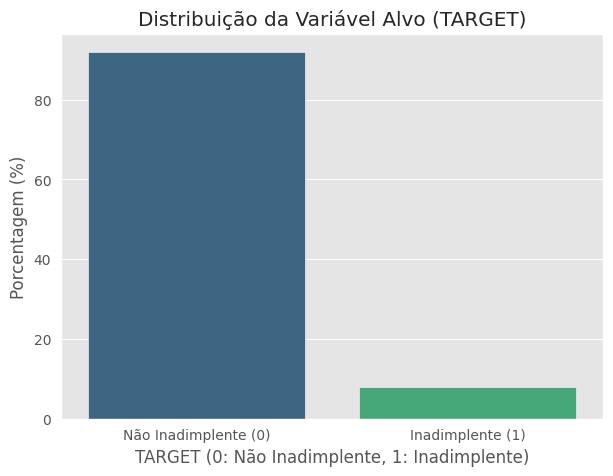


Atenção: A variável TARGET está desbalanceada. A classe minoritária (inadimplentes) representa uma pequena porcentagem.
Isso pode exigir técnicas de balanceamento de classes (ex: SMOTE, undersampling) durante o pré-processamento.


In [ ]:
# Esta seção foca em entender a distribuição dos dados, identificar padrões e verificar a qualidade das features.

print("\n--- Iniciando Análise Exploratória de Dados (EDA) ---")

# 1. Verificando as informações gerais do DataFrame (tipos de dados, contagem de não nulos)
print("\nInformações do DataFrame após pré-processamento inicial:")
app_train.info(verbose=True, show_counts=True) # show_counts para ver a contagem de não-nulos em cada coluna

# 2. Estatísticas descritivas das variáveis numéricas
print("\nEstatísticas descritivas das variáveis numéricas:")
print(app_train.describe())

# 3. Análise da Variável Alvo (TARGET)
# É crucial entender o balanceamento da classe (inadimplentes vs. não inadimplentes).
print("\nDistribuição da variável TARGET:")
target_distribution = app_train['TARGET'].value_counts(normalize=True) * 100
print(target_distribution)

plt.figure(figsize=(7, 5))
sns.barplot(x=target_distribution.index, y=target_distribution.values, palette='viridis')
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.xlabel('TARGET (0: Não Inadimplente, 1: Inadimplente)')
plt.ylabel('Porcentagem (%)')
plt.xticks([0, 1], ['Não Inadimplente (0)', 'Inadimplente (1)'])
plt.show()

if target_distribution[1] < 20: # Exemplo de threshold para considerar desbalanceado
    print("\nAtenção: A variável TARGET está desbalanceada. A classe minoritária (inadimplentes) representa uma pequena porcentagem.")
    print("Isso pode exigir técnicas de balanceamento de classes (ex: SMOTE, undersampling) durante o pré-processamento.")

### 8  Análise Exploratória de Dados (EDA) - Valores Ausentes e Correlações


Verificando valores ausentes no DataFrame (deve ser 0 após fillna):
Não há valores ausentes no DataFrame após o preenchimento inicial com 0.

Top 15 Features mais correlacionadas com a TARGET:
TARGET                          1.000000
EXT_SOURCE_2                    0.159030
EXT_SOURCE_3                    0.119572
DAYS_BIRTH                      0.078239
prev_prev_app_refused_ratio     0.077894
bureau_b_credit_closed_ratio    0.076501
bureau_b_days_credit_min        0.072869
EXT_SOURCE_1                    0.064698
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
DAYS_LAST_PHONE_CHANGE          0.055217
bureau_b_days_credit_max        0.052740
DAYS_ID_PUBLISH                 0.051457
REG_CITY_NOT_WORK_CITY          0.050994
FLOORSMAX_AVG                   0.049839
FLOORSMAX_MEDI                  0.049720
Name: TARGET, dtype: float64


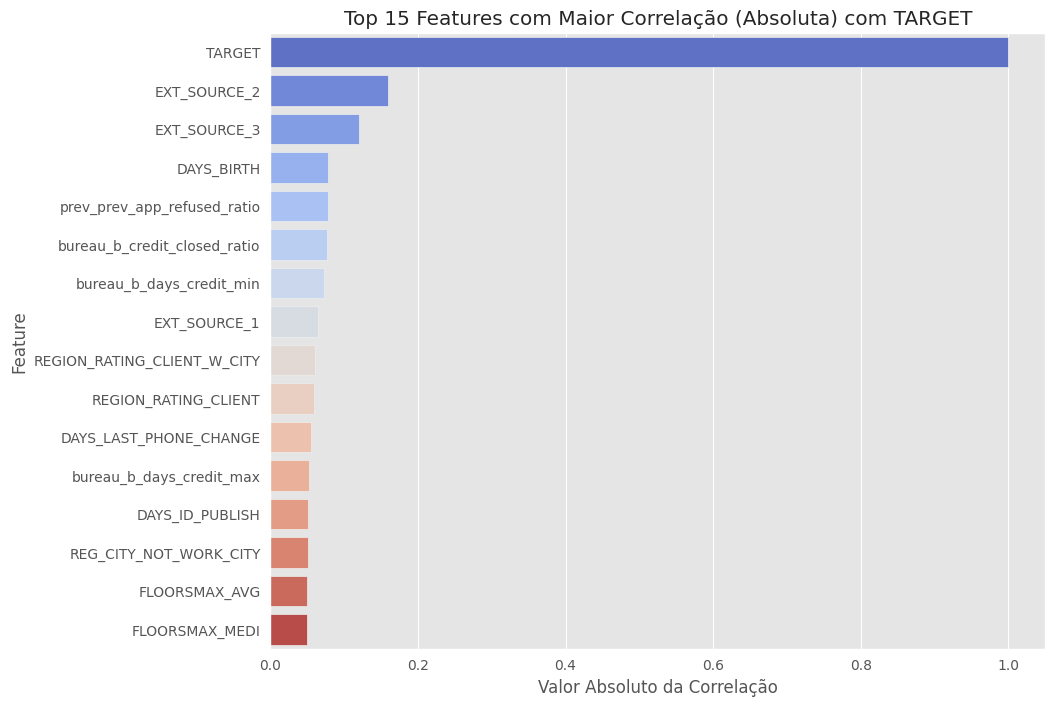

In [ ]:
print("\nVerificando valores ausentes no DataFrame (deve ser 0 após fillna):")
missing_data_after_fillna = app_train.isnull().sum()
missing_data_after_fillna = missing_data_after_fillna[missing_data_after_fillna > 0].sort_values(ascending=False)
if not missing_data_after_fillna.empty:
    print("Colunas com valores ausentes remanescentes:")
    print(missing_data_after_fillna)
else:
    print("Não há valores ausentes no DataFrame após o preenchimento inicial com 0.")

print("\nTop 15 Features mais correlacionadas com a TARGET:")
correlation_with_target = app_train.corr(numeric_only=True)['TARGET'].abs().sort_values(ascending=False)
print(correlation_with_target.head(16)) # Inclui a própria TARGET, então pegamos 16 para as top 15 features

# Visualizando a correlação das top features com a TARGET
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_with_target.head(16).values, y=correlation_with_target.head(16).index, palette='coolwarm')
plt.title('Top 15 Features com Maior Correlação (Absoluta) com TARGET')
plt.xlabel('Valor Absoluto da Correlação')
plt.ylabel('Feature')
plt.show()


### 9 Análise Exploratória de Dados (EDA) - Distribuições Numéricas e Categóricas

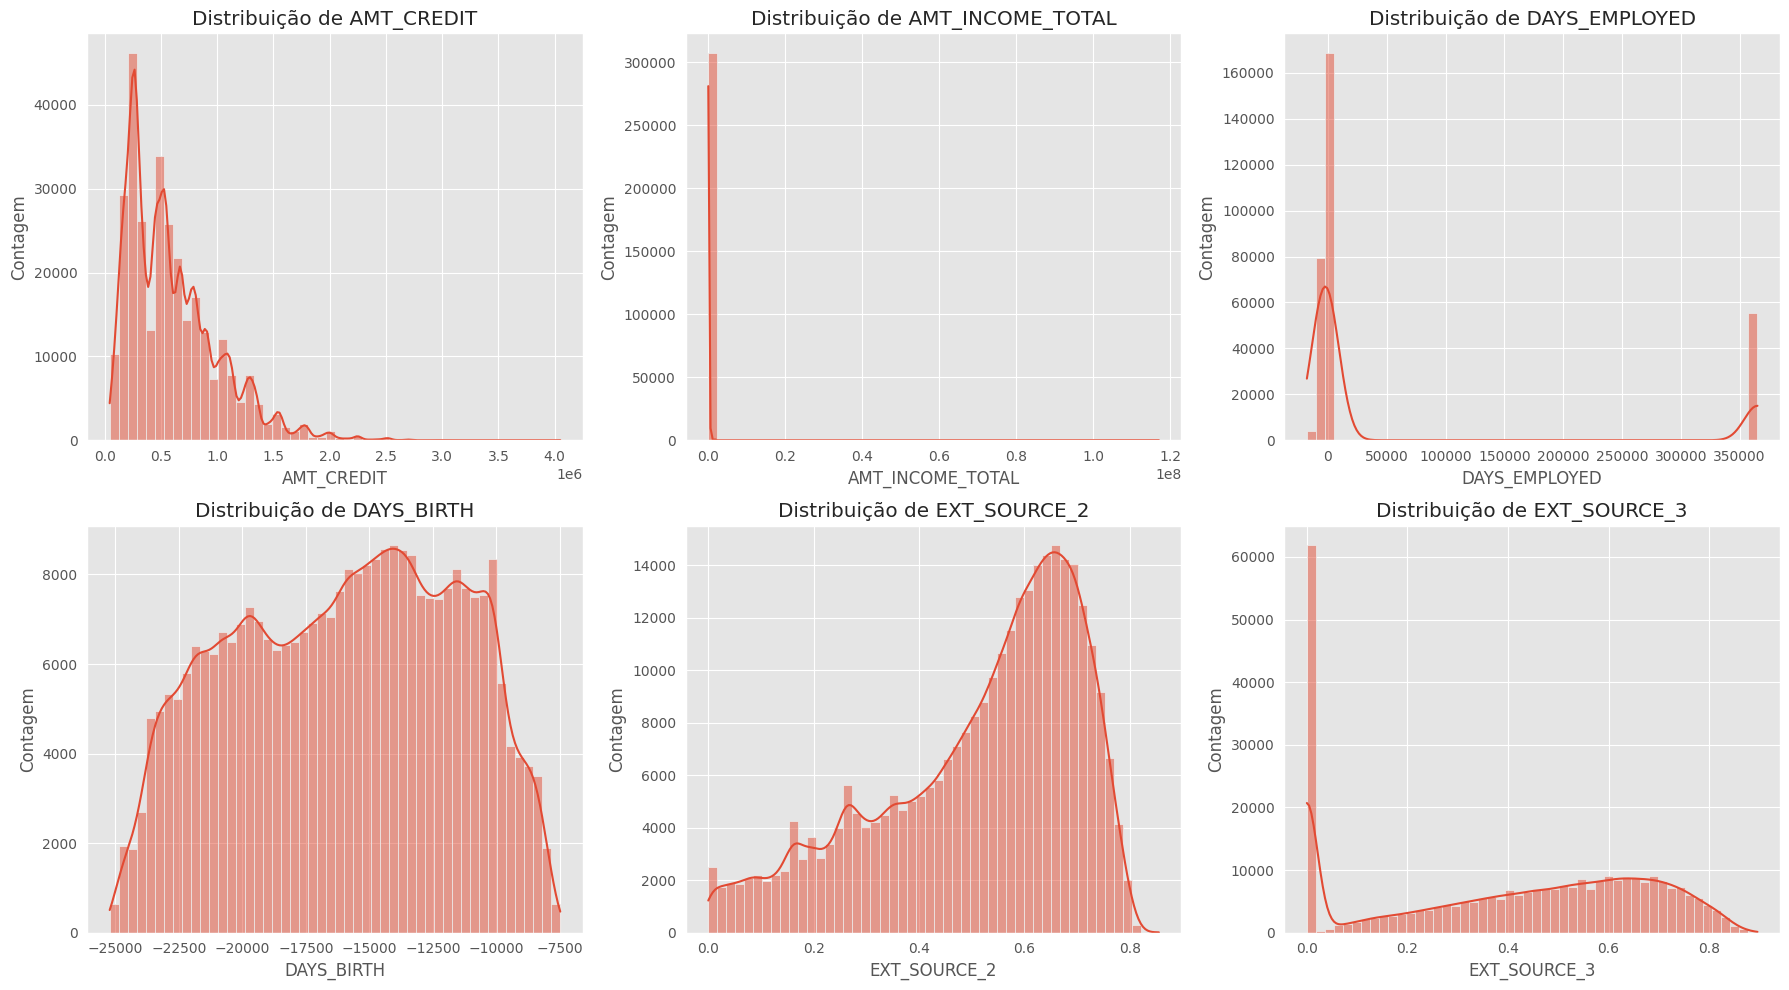

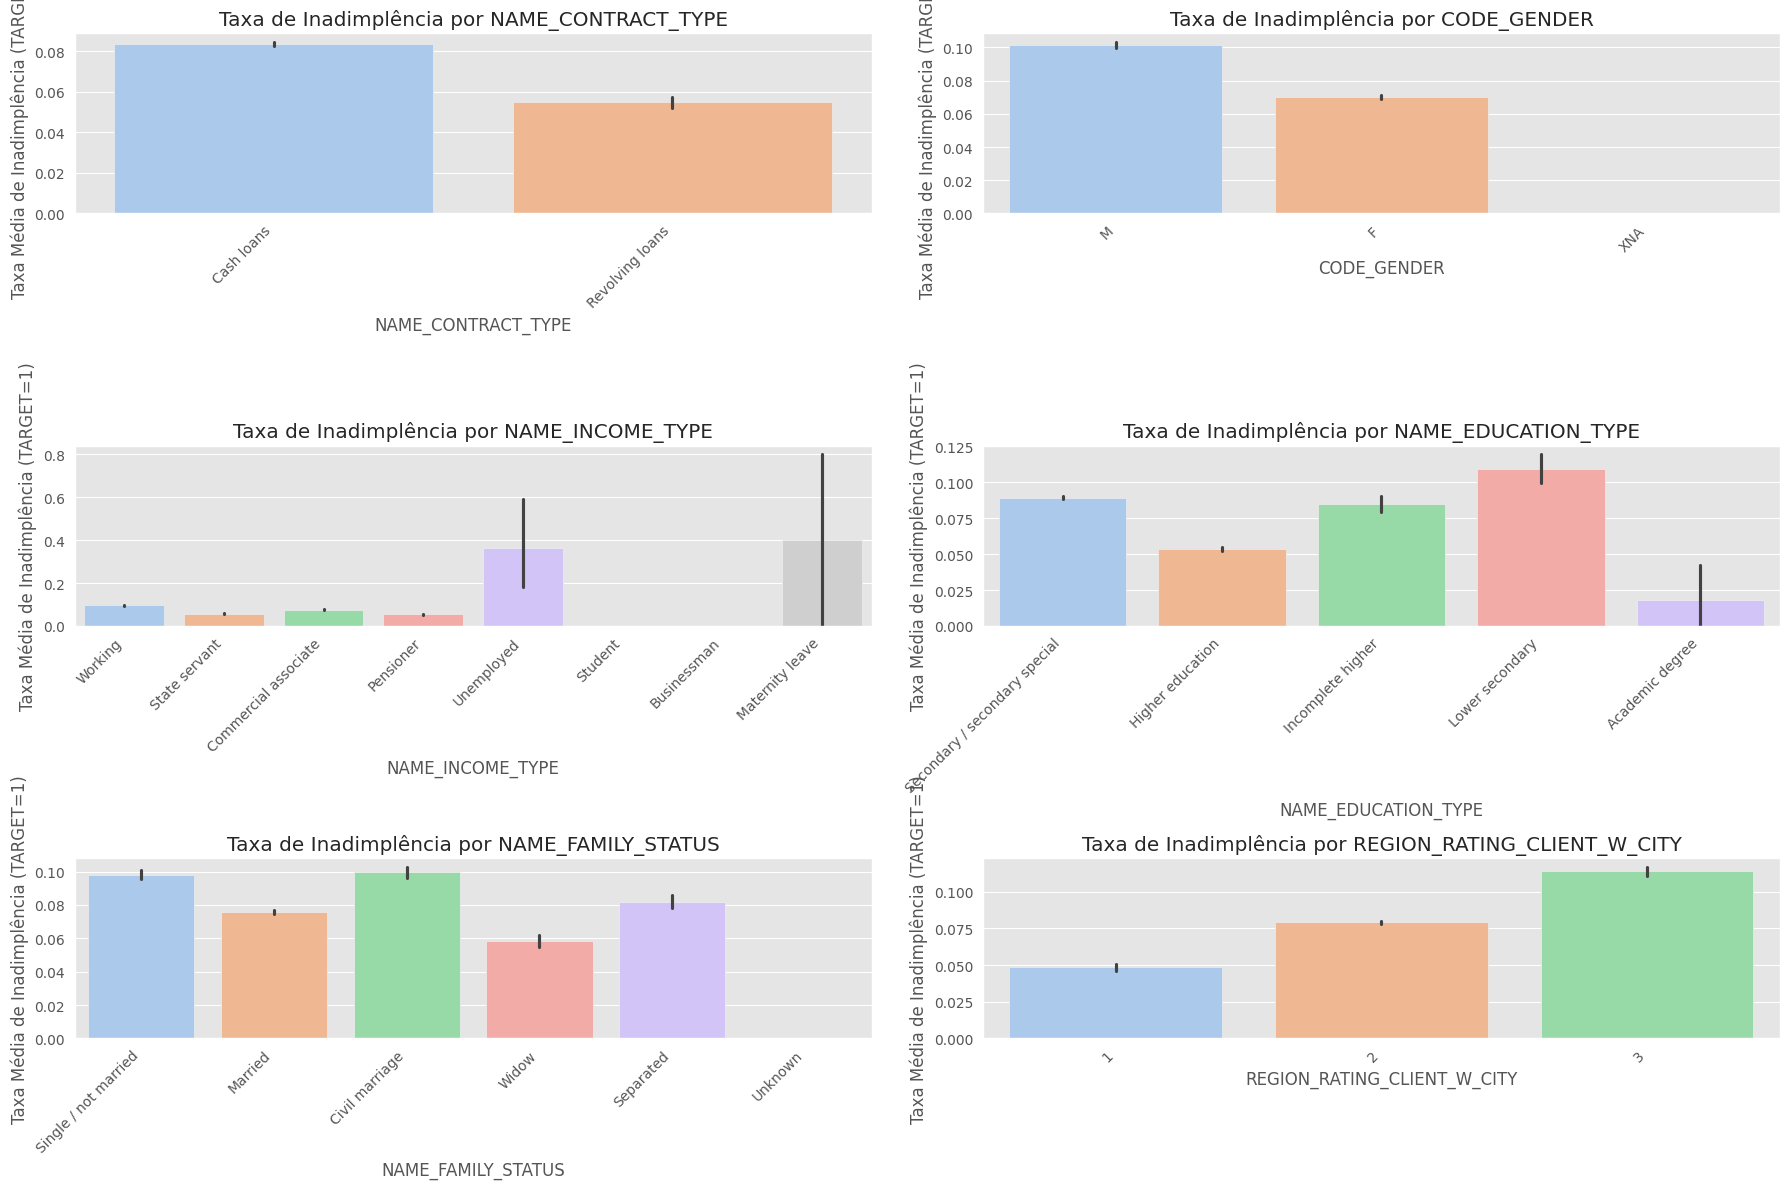


--- EDA Concluída ---


In [ ]:
numeric_features_to_plot = ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

plt.figure(figsize=(18, 10))
for i, col in enumerate(numeric_features_to_plot):
    plt.subplot(2, 3, i + 1)
    sns.histplot(app_train[col], kde=True, bins=50)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Contagem')
plt.tight_layout()
plt.show()


categorical_features_to_plot = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'REGION_RATING_CLIENT_W_CITY']

plt.figure(figsize=(18, 12))
for i, col in enumerate(categorical_features_to_plot):
    plt.subplot(3, 2, i + 1)
    sns.barplot(x=col, y='TARGET', data=app_train, palette='pastel')
    plt.title(f'Taxa de Inadimplência por {col}')
    plt.xlabel(col)
    plt.ylabel('Taxa Média de Inadimplência (TARGET=1)')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- EDA Concluída ---")

### 10 Pré-processamento dos Dados (Divisão X/y e Label Encoding)

In [ ]:
print("\n--- Iniciando Pré-processamento dos Dados ---")

X = app_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = app_train['TARGET']

categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

print(f"Variáveis Categóricas ({len(categorical_cols)}): {list(categorical_cols)}")
print(f"Variáveis Numéricas ({len(numerical_cols)}): {list(numerical_cols)}")

for col in categorical_cols:

    X[col] = X[col].astype(str)
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    print(f"Label Encoding aplicado em: {col}")



--- Iniciando Pré-processamento dos Dados ---
Variáveis Categóricas (17): ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'prev_prev_app_weekday_app_mode']
Variáveis Numéricas (131): ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT

###  11 Pré-processamento dos Dados (Escalonamento e Divisão Treino/Teste)

In [ ]:
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
print("\nEscalonamento de variáveis numéricas com StandardScaler concluído.")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nShape do conjunto de treino (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Shape do conjunto de teste (X_test, y_test): {X_test.shape}, {y_test.shape}")

print("\n--- Pré-processamento Concluído ---")


Escalonamento de variáveis numéricas com StandardScaler concluído.

Shape do conjunto de treino (X_train, y_train): (246008, 148), (246008,)
Shape do conjunto de teste (X_test, y_test): (61503, 148), (61503,)

--- Pré-processamento Concluído ---


### 12 Treinamento do Modelo (Regressão Logística)

In [ ]:
print("\n--- Iniciando Treinamento dos Modelos ---")

print("Iniciando treinamento da Regressão Logística...")

log_reg = LogisticRegression(random_state=42, solver='liblinear', C=0.1, max_iter=2000, class_weight='balanced')

log_reg.fit(X_train, y_train)
print("Regressão Logística treinada.")


--- Iniciando Treinamento dos Modelos ---
Iniciando treinamento da Regressão Logística...
Regressão Logística treinada.


### 13 Treinamento do Modelo (XGBoost)

In [ ]:
print("\nIniciando treinamento do XGBoost...")

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_clf = XGBClassifier(random_state=42,
                        use_label_encoder=False,
                        eval_metric='logloss',
                        n_estimators=1000,
                        learning_rate=0.03,
                        max_depth=7,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        gamma=0.1,
                        reg_alpha=0.005,
                        scale_pos_weight=scale_pos_weight
                       )
xgb_clf.fit(X_train, y_train)
print("XGBoost treinado.")

print("\n--- Treinamento dos Modelos Concluído ---")


Iniciando treinamento do XGBoost...
XGBoost treinado.

--- Treinamento dos Modelos Concluído ---


### 14 Função Auxiliar para Avaliação dos Modelos

In [ ]:
# Esta seção avalia o desempenho dos modelos treinados utilizando métricas de classificação
# como Relatório de Classificação (Precision, Recall, F1-Score), Matriz de Confusão e Curva ROC (com AUC Score).

print("\n--- Iniciando Avaliação dos Modelos ---")


def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n--- Avaliação do Modelo: {model_name} ---")


    y_pred = model.predict(X_test)

    y_proba = model.predict_proba(X_test)[:, 1]


    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))


    print("\nMatriz de Confusão:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Previsto: Não Inadimplente (0)', 'Previsto: Inadimplente (1)'],
                yticklabels=['Real: Não Inadimplente (0)', 'Real: Inadimplente (1)'])
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Valores Reais')
    plt.xlabel('Valores Preditos')
    plt.show()


    auc_score = roc_auc_score(y_test, y_proba)
    print(f"\nAUC Score: {auc_score:.4f}")


    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
    plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


--- Iniciando Avaliação dos Modelos ---


### 15 Avaliação do Modelo (Regressão Logística)


--- Avaliação do Modelo: Regressão Logística ---

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503


Matriz de Confusão:
[[38956 17582]
 [ 1571  3394]]


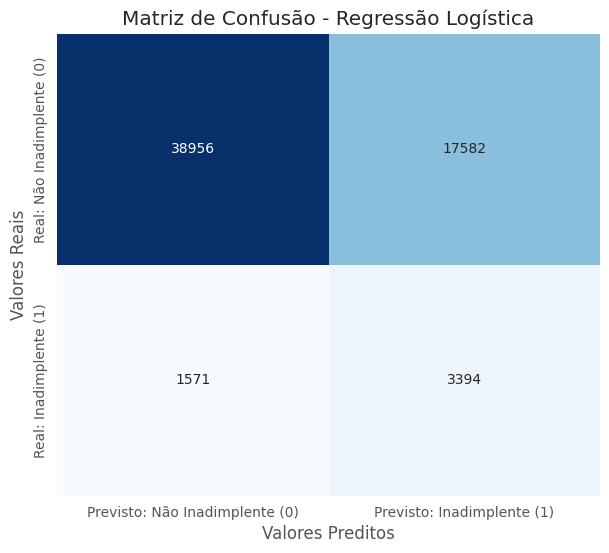


AUC Score: 0.7513


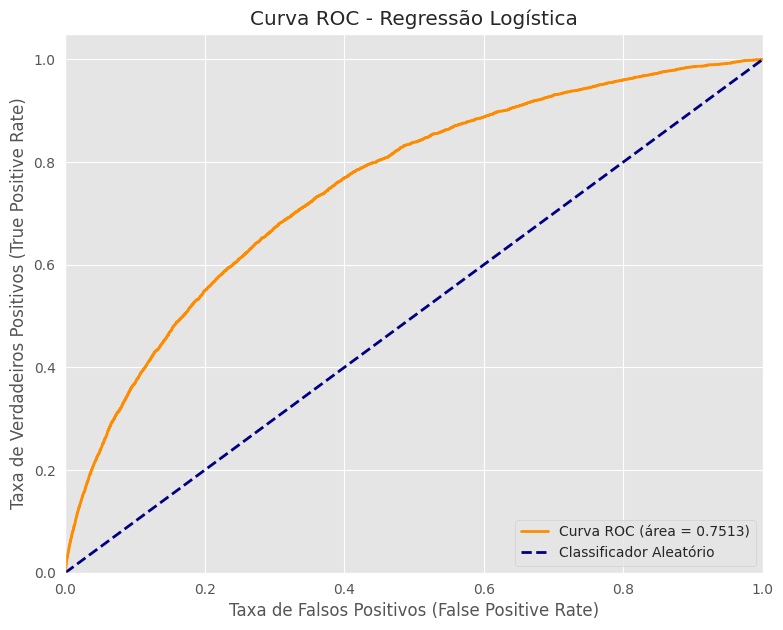

In [ ]:
evaluate_model(log_reg, X_test, y_test, "Regressão Logística")

### 16 Avaliação do Modelo (XGBoost)


--- Avaliação do Modelo: XGBoost ---

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     56538
           1       0.21      0.57      0.31      4965

    accuracy                           0.79     61503
   macro avg       0.58      0.69      0.59     61503
weighted avg       0.90      0.79      0.83     61503


Matriz de Confusão:
[[45814 10724]
 [ 2130  2835]]


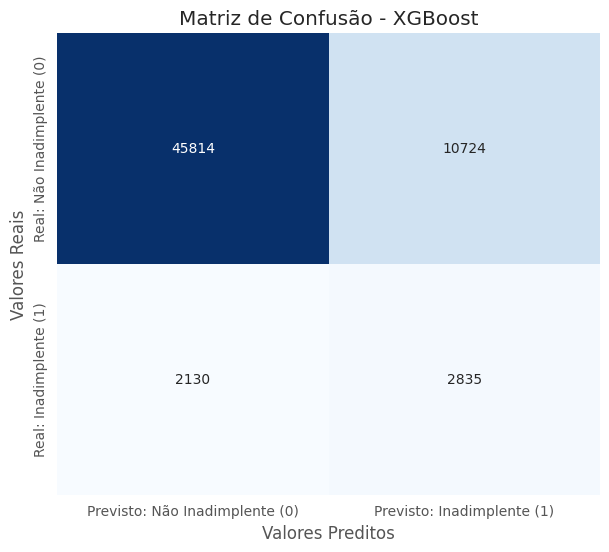


AUC Score: 0.7692


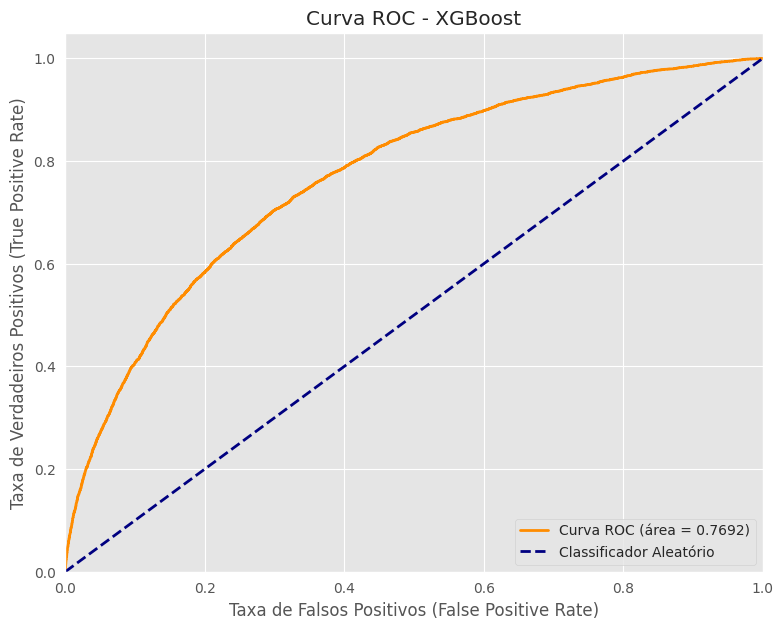


--- Avaliação dos Modelos Concluída ---


In [ ]:
evaluate_model(xgb_clf, X_test, y_test, "XGBoost")

print("\n--- Avaliação dos Modelos Concluída ---")